In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# Load the combined securities dataframe
df = pd.read_excel("etf_combined.xlsx", index_col='Date', parse_dates=True)
df = df.dropna(axis=1)

log_returns = np.log(df / df.shift(1)).dropna()

In [48]:
from sklearn.covariance import LedoitWolf, OAS

lw = LedoitWolf().fit(log_returns.values)
oas = OAS().fit(log_returns.values)

cov_lw = pd.DataFrame(lw.covariance_, index=log_returns.columns, columns=log_returns.columns)
cov_oas = pd.DataFrame(oas.covariance_, index=log_returns.columns, columns=log_returns.columns)

In [49]:
from sklearn.decomposition import PCA

def denoise_corr(corr, n_factors=None):
    pca = PCA()
    pca.fit(corr)
    ev = pca.explained_variance_

    if n_factors is None:
        # Marchenko–Pastur thresholding rule of thumb
        q = corr.shape[0] / corr.shape[1]
        lambda_plus = (1 + (1/np.sqrt(q)))**2
        n_factors = np.sum(ev > lambda_plus)

    X = pca.components_[:n_factors].T @ np.diag(ev[:n_factors]) @ pca.components_[:n_factors]
    diag = np.diag(np.diag(corr.values))
    return pd.DataFrame(X + diag, index=corr.index, columns=corr.columns)

corr = log_returns.corr()
denoised_corr = denoise_corr(corr)

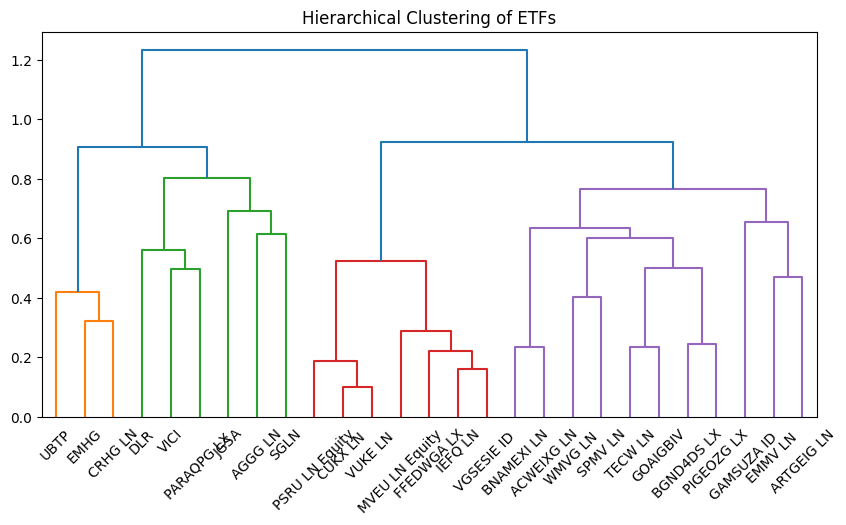

In [50]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Convert correlation matrix to distance matrix
distance_matrix = np.sqrt(0.5 * (1 - corr))
link = linkage(squareform(distance_matrix), method='ward')

# Plot dendrogram (like PortfolioLab)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
dendrogram(link, labels=corr.columns)
plt.title("Hierarchical Clustering of ETFs")
plt.show()

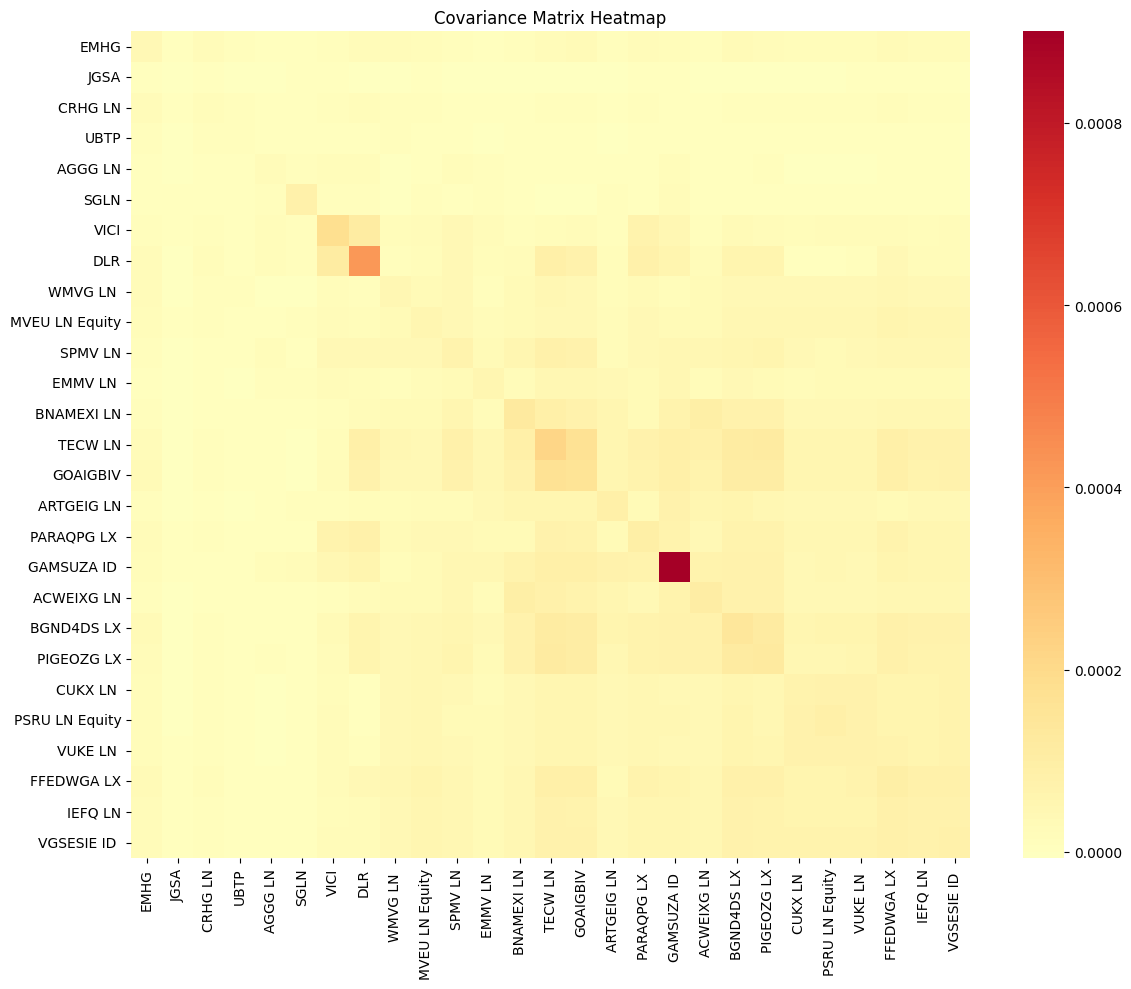

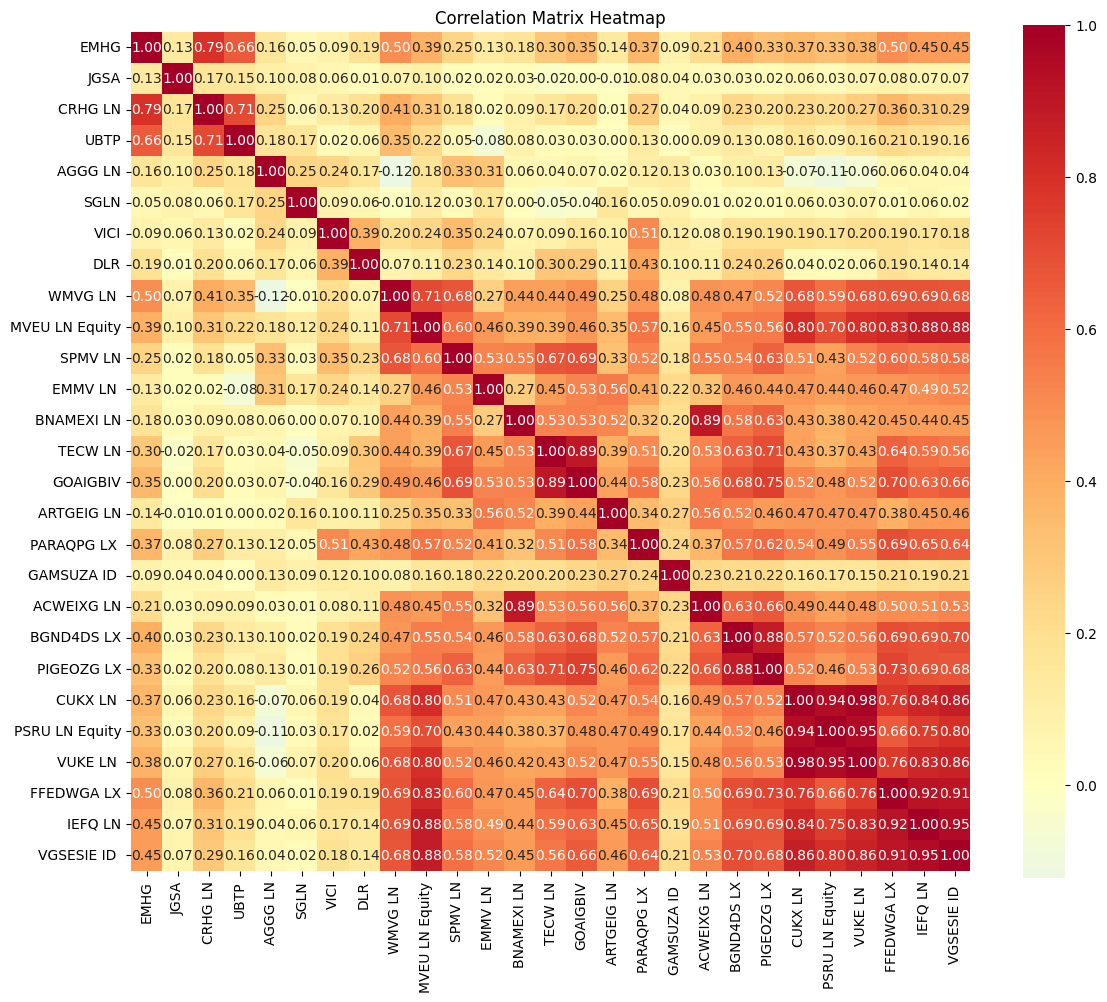

In [51]:
# Calculate covariance matrix
cov_matrix = log_returns.cov()
# print(cov_matrix)

# Calculate the correlation matrix
corr_matrix = log_returns.corr()

# Visualize covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix, annot=False, cmap='RdYlBu_r', center=0)
plt.title('Covariance Matrix Heatmap')
plt.tight_layout()
plt.show()

# Visualize correlation matrix (usually more readable)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.2f', square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()